# IPCA Asset Pricing

Replication of Kelly, Pruitt, Su (2019) Table 2 using ALS IPCA.

**Paper Results (Table 2):**

| Sample | Total R² | Predictive R² |
|--------|----------|---------------|
| Incumbent stocks (in-sample) | 15.66% | 0.25% |
| New listings (out-of-sample) | 13.44% | 0.22% |

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

from als_ipca import ALSIPCA
from data_loader import ensure_data
from data_utils import (
    next_month,
    rank_transform,
    create_balanced_panel,
    compute_r2,
    compute_oos_r2
)

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
plt.rcParams['figure.figsize'] = (12, 6)

# Download data if not present
ensure_data()

print("Imports successful.")

Imports successful.


---
## 1. Load Data

In [2]:
%%time
print("Loading datashare.csv...")
datashare = pd.read_csv('../data/datashare.csv', low_memory=False)
datashare['YYYYMM'] = datashare['DATE'] // 100
print(f"Datashare: {len(datashare):,} rows")

Loading datashare.csv...
Datashare: 3,760,208 rows
CPU times: user 42.2 s, sys: 3.9 s, total: 46.1 s
Wall time: 48.6 s


In [3]:
%%time
print("Loading crsp_monthly_returns.csv...")
crsp = pd.read_csv('../data/crsp_monthly_returns.csv', usecols=['PERMNO', 'YYYYMM', 'MthRet'])
crsp = crsp.dropna(subset=['MthRet'])
crsp = crsp.rename(columns={'PERMNO': 'permno', 'MthRet': 'ret'})
print(f"CRSP: {len(crsp):,} rows")

Loading crsp_monthly_returns.csv...
CRSP: 3,962,057 rows
CPU times: user 6.15 s, sys: 361 ms, total: 6.51 s
Wall time: 7.82 s


---
## 2. Merge with Lagged Characteristics

Characteristics at time $t$ predict returns at time $t+1$.

In [4]:
%%time
# Create lagged merge key
datashare['YYYYMM_next'] = datashare['YYYYMM'].apply(next_month)

# Merge: characteristics at t with returns at t+1
df = datashare.merge(
    crsp,
    left_on=['permno', 'YYYYMM_next'],
    right_on=['permno', 'YYYYMM'],
    how='inner',
    suffixes=('_char', '_ret')
)

df['YYYYMM'] = df['YYYYMM_ret']
df = df.drop(columns=['DATE', 'YYYYMM_char', 'YYYYMM_next', 'YYYYMM_ret'])

print(f"Merged: {len(df):,} observations")
print(f"Unique stocks: {df['permno'].nunique():,}")

del datashare, crsp
gc.collect()

Merged: 3,770,311 observations
Unique stocks: 29,807
CPU times: user 1.82 s, sys: 1.07 s, total: 2.89 s
Wall time: 3 s


0

In [5]:
# Filter to 1985-2015
df = df[(df['YYYYMM'] >= 198501) & (df['YYYYMM'] <= 201512)]
print(f"After filtering to 1985-2015: {len(df):,} observations")
print(f"Date range: {df['YYYYMM'].min()} to {df['YYYYMM'].max()}")

After filtering to 1985-2015: 2,596,642 observations
Date range: 198501 to 201512


In [6]:
# Identify characteristic columns
EXCLUDE_COLS = ['permno', 'YYYYMM', 'ret', 'sic2']
CHAR_COLS = [c for c in df.columns if c not in EXCLUDE_COLS]
print(f"Characteristics: {len(CHAR_COLS)}")

Characteristics: 94


---
## 3. Rank Transformation

Transform characteristics to cross-sectional ranks in [-0.5, 0.5].

In [7]:
%%time
print("Transforming to cross-sectional ranks...")
df_ranked = rank_transform(df, CHAR_COLS, time_col='YYYYMM')
print("Done.")

del df
gc.collect()

Transforming to cross-sectional ranks...
Done.
CPU times: user 27.7 s, sys: 3.91 s, total: 31.7 s
Wall time: 32.5 s


0

---
## 4. Split: Incumbent vs New Listings

In [8]:
# IPO = first appearance in sample
first_appearance = df_ranked.groupby('permno')['YYYYMM'].min().reset_index()
first_appearance.columns = ['permno', 'ipo_yyyymm']
df_ranked = df_ranked.merge(first_appearance, on='permno', how='left')

# Months since IPO
df_ranked['months_since_ipo'] = (
    (df_ranked['YYYYMM'] // 100 - df_ranked['ipo_yyyymm'] // 100) * 12 +
    (df_ranked['YYYYMM'] % 100 - df_ranked['ipo_yyyymm'] % 100)
)

# New listings: first 12 months
is_new_listing = df_ranked['months_since_ipo'] < 12
df_ranked = df_ranked.drop(columns=['ipo_yyyymm', 'months_since_ipo'])

print(f"Incumbent: {(~is_new_listing).sum():,} ({(~is_new_listing).mean()*100:.1f}%)")
print(f"New listings: {is_new_listing.sum():,} ({is_new_listing.mean()*100:.1f}%)")

Incumbent: 2,307,110 (88.8%)
New listings: 289,532 (11.2%)


In [9]:
df_incumbent = df_ranked[~is_new_listing].copy()
df_new_listings = df_ranked[is_new_listing].copy()

del df_ranked
gc.collect()

0

---
## 5. Prepare Balanced Panel for ALS IPCA

In [10]:
%%time
rets, Z, times, stocks, T, N, L = create_balanced_panel(
    df_incumbent, CHAR_COLS, 
    min_obs_per_stock=60, 
    max_stocks=500, 
    add_intercept=True,
    verbose=True
)

print(f"\nFinal dimensions: T={T}, N={N}, L={L}")

Stocks with >= 60 observations: 12322
Stocks present in all 360 periods: 722
Limiting to 500 stocks

Creating arrays: T=360, N=500, L=95

Final dimensions: T=360, N=500, L=95
CPU times: user 21.3 s, sys: 611 ms, total: 21.9 s
Wall time: 22 s


---
## 6. Fit ALS IPCA

In [11]:
K = 5  # Number of factors
print(f"IPCA with K={K} factors, L={L} characteristics")
print(f"Data: T={T} periods, N={N} assets")

IPCA with K=5 factors, L=95 characteristics
Data: T=360 periods, N=500 assets


In [12]:
%%time
model = ALSIPCA(num_assets=N, num_fact=K, num_charact=L, win_len=T)

data = [rets, Z]
Gamma_hat, history = model.fit(
    data,
    max_iter=1000,
    tol=1e-6,
    verbose=True,
    seed=42
)

Iteration    0: Objective = 4.984544
Iteration    1: Objective = 4.499615, Gamma change = 0.73113343, Factor change = 0.00000000
Iteration    2: Objective = 4.447875, Gamma change = 1.06646164, Factor change = 2.10034688
Iteration    3: Objective = 4.430233, Gamma change = 0.09838232, Factor change = 2.33229051
Iteration    4: Objective = 4.424199, Gamma change = 0.07969679, Factor change = 0.49035696
Iteration    5: Objective = 4.421783, Gamma change = 0.06361949, Factor change = 0.49033613
Iteration    6: Objective = 4.420621, Gamma change = 0.04459076, Factor change = 0.52384500
Iteration    7: Objective = 4.419992, Gamma change = 0.03222430, Factor change = 0.45863948
Iteration    8: Objective = 4.419633, Gamma change = 0.02312415, Factor change = 0.36268871
Iteration    9: Objective = 4.419421, Gamma change = 0.01687753, Factor change = 0.27218011
Iteration   10: Objective = 4.419295, Gamma change = 0.01219133, Factor change = 0.19909045
Iteration   11: Objective = 4.419219, Gamma

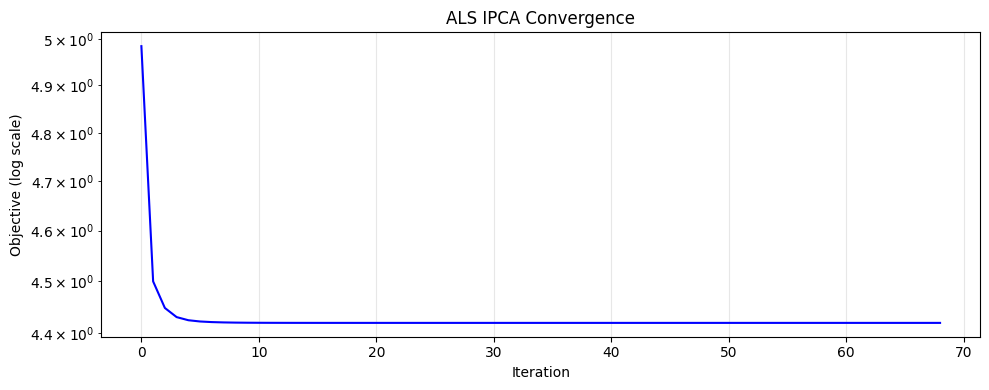

In [13]:
# Plot convergence
fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(history, 'b-', lw=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective (log scale)')
ax.set_title('ALS IPCA Convergence')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 7. In-Sample R²

In [14]:
results = model.get_results()
Gamma = results['Gamma']
factors = results['factors']
Lambda = results['Lambda']

r2_total_is, r2_pred_is = compute_r2(rets, Z, Gamma, factors, Lambda)

print("IN-SAMPLE RESULTS (Incumbent Stocks)")
print("=" * 50)
print(f"Total R²:      {r2_total_is*100:.2f}%  (paper: 15.66%)")
print(f"Predictive R²: {r2_pred_is*100:.2f}%  (paper: 0.25%)")

IN-SAMPLE RESULTS (Incumbent Stocks)
Total R²:      28.80%  (paper: 15.66%)
Predictive R²: 1.40%  (paper: 0.25%)


---
## 8. Out-of-Sample R² (New Listings)

In [15]:
# Filter new listings to same time periods
df_new = df_new_listings[df_new_listings['YYYYMM'].isin(times)].copy()
print(f"New listings observations: {len(df_new):,}")

New listings observations: 214,014


In [16]:
%%time
r2_total_oos, r2_pred_oos = compute_oos_r2(
    df_new, CHAR_COLS, Gamma, factors, Lambda, times, add_intercept=True
)

print("OUT-OF-SAMPLE RESULTS (New Listings)")
print("=" * 50)
print(f"Total R²:      {r2_total_oos*100:.2f}%  (paper: 13.44%)")
print(f"Predictive R²: {r2_pred_oos*100:.2f}%  (paper: 0.22%)")

OUT-OF-SAMPLE RESULTS (New Listings)
Total R²:      9.30%  (paper: 13.44%)
Predictive R²: -0.49%  (paper: 0.22%)
CPU times: user 5.6 s, sys: 185 ms, total: 5.79 s
Wall time: 5.56 s


---
## 9. Summary: Comparison with Paper

In [17]:
print("=" * 70)
print("COMPARISON WITH PAPER (Table 2)")
print("=" * 70)
print(f"""
+-----------------------------+------------+---------------+
| Sample                      | Total R²   | Predictive R² |
+-----------------------------+------------+---------------+
| PAPER - Incumbent           |   15.66%   |      0.25%    |
| ALS IPCA - Incumbent        |   {r2_total_is*100:>5.2f}%   |      {r2_pred_is*100:>4.2f}%    |
+-----------------------------+------------+---------------+
| PAPER - New Listings        |   13.44%   |      0.22%    |
| ALS IPCA - New Listings     |   {r2_total_oos*100:>5.2f}%   |     {r2_pred_oos*100:>5.2f}%    |
+-----------------------------+------------+---------------+
""")
print(f"Model: K={K} factors, L={len(CHAR_COLS)} characteristics + intercept")
print(f"Sample: T={T} months, N={N} stocks")

COMPARISON WITH PAPER (Table 2)

+-----------------------------+------------+---------------+
| Sample                      | Total R²   | Predictive R² |
+-----------------------------+------------+---------------+
| PAPER - Incumbent           |   15.66%   |      0.25%    |
| ALS IPCA - Incumbent        |   28.80%   |      1.40%    |
+-----------------------------+------------+---------------+
| PAPER - New Listings        |   13.44%   |      0.22%    |
| ALS IPCA - New Listings     |    9.30%   |     -0.49%    |
+-----------------------------+------------+---------------+

Model: K=5 factors, L=94 characteristics + intercept
Sample: T=360 months, N=500 stocks


---
## 10. Visualizations

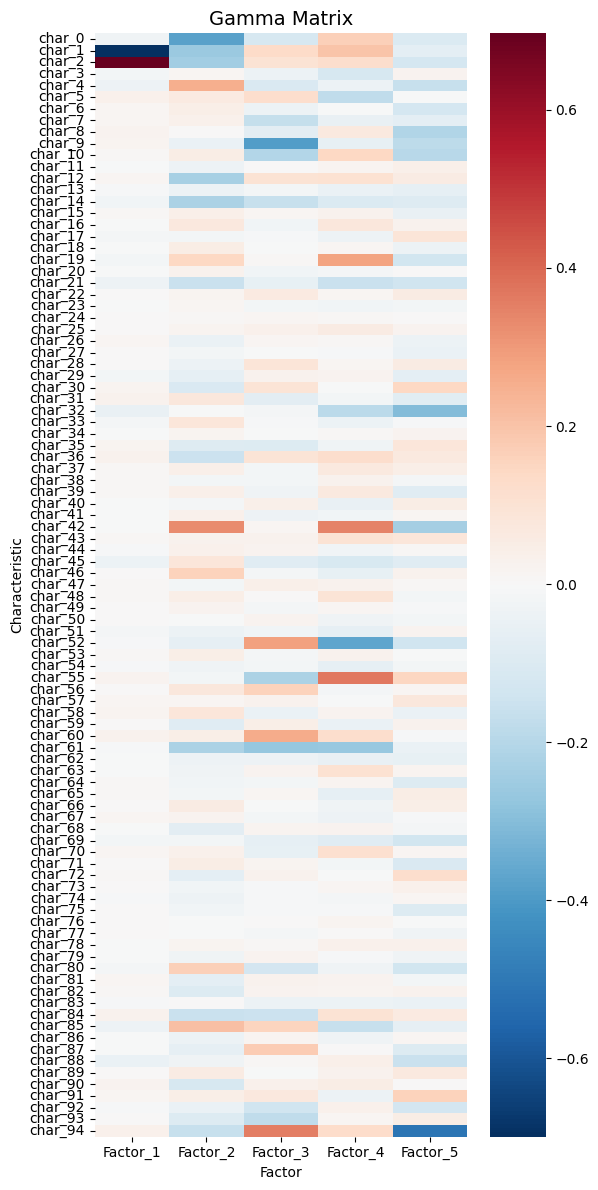

In [18]:
# Gamma heatmap
fig, ax = plt.subplots(figsize=(6, 12))
sns.heatmap(Gamma, cmap='RdBu_r', center=0, ax=ax,
            yticklabels=Gamma.index, xticklabels=Gamma.columns)
ax.set_title('Gamma Matrix', fontsize=14)
ax.set_xlabel('Factor')
ax.set_ylabel('Characteristic')
plt.tight_layout()
plt.show()

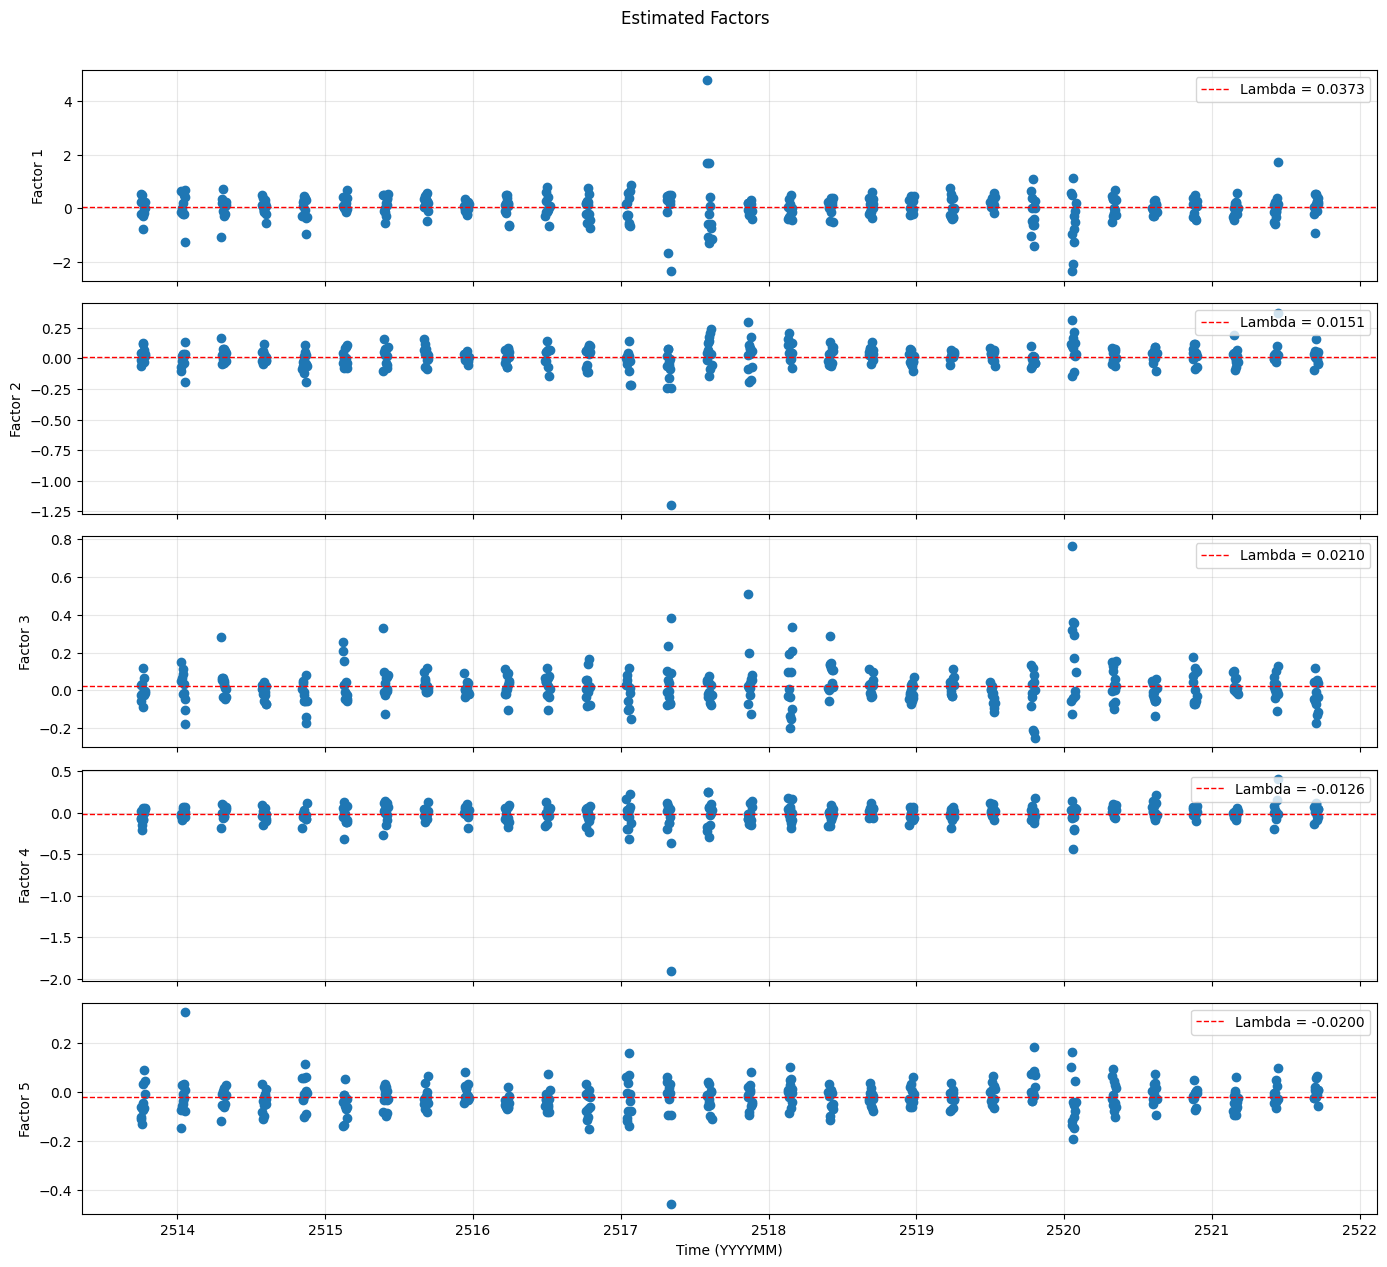

In [21]:
# Factor time series
fig, axes = plt.subplots(K, 1, figsize=(14, 2.5*K), sharex=True)

for i in range(K):
    ax = axes[i]
    factor_vals = factors.iloc[i, :].values
    ax.plot_date(times, factor_vals, lw=0.8)
    ax.axhline(Lambda.iloc[i], c='r', ls='--', lw=1, label=f'Lambda = {Lambda.iloc[i]:.4f}')
    ax.set_ylabel(f'Factor {i+1}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (YYYYMM)')
fig.suptitle('Estimated Factors', y=1.01)
plt.tight_layout()
plt.show()

In [20]:
# Top characteristics by absolute loading
print("Top 10 Characteristics by Absolute Loading:")
print("=" * 60)

for col in Gamma.columns:
    print(f"\n{col}:")
    top_chars = Gamma[col].abs().nlargest(10)
    for char in top_chars.index:
        val = Gamma.loc[char, col]
        sign = '+' if val > 0 else '-'
        print(f"  {sign} {char}: {val:.4f}")

Top 10 Characteristics by Absolute Loading:

Factor_1:
  - char_1: -0.6991
  + char_2: 0.6967
  - char_32: -0.0519
  - char_88: -0.0474
  - char_45: -0.0436
  - char_85: -0.0380
  - char_4: -0.0366
  + char_5: 0.0348
  + char_94: 0.0344
  - char_21: -0.0342

Factor_2:
  - char_0: -0.3787
  + char_42: 0.3267
  - char_1: -0.2623
  + char_4: 0.2550
  - char_2: -0.2453
  - char_12: -0.2307
  - char_61: -0.2204
  - char_14: -0.2199
  + char_85: 0.2061
  + char_80: 0.1638

Factor_3:
  - char_9: -0.3886
  + char_94: 0.3556
  + char_52: 0.2854
  - char_61: -0.2710
  + char_60: 0.2583
  - char_55: -0.2204
  - char_10: -0.2038
  - char_93: -0.1783
  + char_87: 0.1776
  - char_7: -0.1659

Factor_4:
  + char_55: 0.3690
  - char_52: -0.3675
  + char_42: 0.3441
  + char_19: 0.2814
  - char_61: -0.2634
  + char_1: 0.1965
  - char_32: -0.1908
  - char_5: -0.1783
  + char_0: 0.1661
  - char_85: -0.1614

Factor_5:
  - char_94: -0.5115
  - char_32: -0.3042
  - char_42: -0.2365
  - char_8: -0.2120
  - cha